In [10]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas as pd

tickerSymbol = 'SPY'

data = pd.read_csv("data_stocks/AAPL.csv")

data.index = pd.to_datetime(data["ts_event"])
data.drop(columns = "ts_event", inplace=True)

#### un an
#data = data[(data.index >=  "2022-10-01") & (data.index <  "2024-01-01")]

display(data)



,open,high,low,close,volume
ts_event,,,,,
2018-05-01,166400000000,178000000000,165270000000,175200000000,13282876
2018-05-02,174920000000,177750000000,173660000000,176500000000,16471381
2018-05-03,176200000000,177500000000,174460000000,176900000000,10238793
2018-05-04,177950000000,184250000000,177480000000,184100000000,14555212
2018-05-07,184450000000,187660000000,184250000000,185000000000,9981580
...,...,...,...,...,...
2024-01-22,191790000000,195330000000,191730000000,193890000000,16111559
2024-01-23,193410000000,195750000000,193010000000,195110000000,11001648
2024-01-24,194920000000,196370000000,193810000000,194000000000,14495772


In [12]:
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from sklearn.metrics import r2_score  as r2
from sklearn.metrics import mean_squared_error as mse
import tqdm


# ARIMA
ts = data['close'].to_numpy()
errors = []
window = []

for trainWindow in tqdm.tqdm(range(5,200)):

    ytrue = ts[trainWindow:]
    ypred = []
    index = [i for i in range(len(ytrue))]

    for i in range(len(ytrue)):
        trainSet = ts[i:i+trainWindow]
        model = pm.auto_arima(trainSet)
        ypred.append(model.predict(n_periods = 1)[0])

    errors.append(mse(ytrue,ypred))
    window.append(trainWindow)

res = pd.DataFrame()
res["TrainingWindow"] = window
res["MSE"] = errors

res.to_csv("MSE_1d_pred_ARIMA.csv")
    


# Plotting the results
plt.figure(figsize=(10, 6))
#plt.plot(index, ytrue, label='Reel value')
#plt.plot(index, ypred, label='Predicted value')
plt.plot(index, np.subtract(ytrue,ypred), label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

print(r2(ytrue,ypred))
print(mse(ytrue,ypred))

  0%|          | 0/195 [00:00<?, ?it/s]

In [8]:
model.order[0]

2

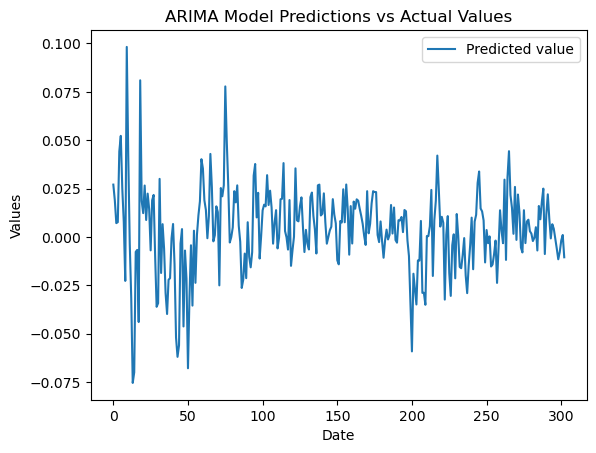

In [4]:
plt.plot(index, np.divide(ytrue,ypred) - 1, label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [5]:
ytrue

array([143430000000, 144810000000, 143000000000, 142640000000,
       147580000000, 149530000000, 150810000000, 149770000000,
       145280000000, 155860000000, 153470000000, 150380000000,
       144120000000, 137710000000, 138070000000, 139010000000,
       139820000000, 135050000000, 147270000000, 149380000000,
       148830000000, 150010000000, 149170000000, 150750000000,
       150970000000, 148060000000, 150060000000, 151170000000,
       148110000000, 144250000000, 140990000000, 148290000000,
       148020000000, 147530000000, 146850000000, 143070000000,
       140990000000, 142700000000, 141990000000, 144370000000,
       145450000000, 143420000000, 136490000000, 134410000000,
       132430000000, 132940000000, 135580000000, 132030000000,
       131750000000, 130000000000, 126260000000, 129360000000,
       130000000000, 124950000000, 126960000000, 125170000000,
       129350000000, 130020000000, 130750000000, 133440000000,
       133180000000, 134550000000, 135600000000, 134790